# Figure 3- V2 Do Not Sacrifice Performance for Speed


# Libraries


In [4]:
import utils as u
import config as c
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, friedmanchisquare, wilcoxon, ks_2samp
import statsmodels.stats.multitest as smm
from itertools import combinations
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import itertools

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Load


In [5]:
tdf = u.load_trials_df()
tdf = u.compute_days_relative_to_stage(tdf, 5)
tdf = u.compute_days_relative_to_stage(tdf, 10)

Loading days data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


In [6]:
probe_violation_df = tdf.query("stage in @c.PROBE_STAGES").groupby(["date", "fix_experiment", "animal_id", "stage", "days_relative_to_stage_10"]).violations.mean().reset_index()
probe_violation_df.rename(columns={"violations": "violation_rate"}, inplace=True)

probe_violation_df["violation_rate"] = probe_violation_df["violation_rate"] * 100

probe_violation_df.head()


,date,fix_experiment,animal_id,stage,days_relative_to_stage_10,violation_rate
0,2024-08-07,V2,R043,9.0,-5.0,14.673913
1,2024-08-08,V2,R043,9.0,-4.0,10.501193
2,2024-08-09,V2,R043,9.0,-3.0,8.184143
3,2024-08-10,V2,R043,9.0,-2.0,4.514673
4,2024-08-11,V1,R042,9.0,-5.0,19.444444


# A


In [7]:
by_stage_stats = probe_violation_df.groupby(['fix_experiment', 'stage'])['violation_rate'].agg(['median', 'mean', 'std', 'size']).reset_index()
by_stage_stats

,fix_experiment,stage,median,mean,std,size
0,V1,9.0,16.231884,15.576289,5.328778,39
1,V1,10.0,7.904282,10.114205,5.536347,40
2,V2,9.0,12.449063,15.600095,8.282522,44
3,V2,10.0,9.294872,12.186297,7.730365,45


In [8]:
combined_stats = probe_violation_df.groupby('fix_experiment')['violation_rate'].agg(['median', 'mean', 'std', 'size']).reset_index()
combined_stats


,fix_experiment,median,mean,std,size
0,V1,12.337662,12.810677,6.059081,79
1,V2,11.079545,13.874017,8.145309,89


/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_77827/2806543067.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Stable\nRequirement", "Random\nRequirement"])


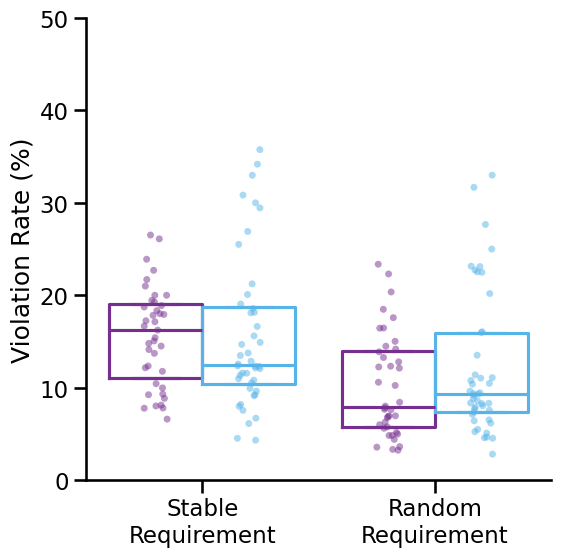

In [9]:
fig, ax = plt.subplots(figsize=(6,6))

u.box_strip_v1_vs_v2(probe_violation_df, x="stage", order=None, y="violation_rate", ax=ax, xlabel="", ylabel="Violation Rate (%)", dodge=True, alpha=0.5, width=0.8)

ax.set_ylim(0, 50)
ax.set_xticklabels(["Stable\nRequirement", "Random\nRequirement"])
ax.legend().remove()

c.save_fig(fig, "fig3_probe_violation_rates_by_stage")

## STATS


In [10]:
st9stats = u.compare_v1_v2(probe_violation_df.query("stage == 9"), "violation_rate")
st9stats



,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,True,False,39,44,mannwhitney,947.5,0.416759


In [11]:
u.compare_v1_v2_multi_sample(probe_violation_df.query("stage == 9"), "violation_rate")

,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,0.031559,0.974824,True


In [12]:
st10stats = u.compare_v1_v2(probe_violation_df.query("stage == 10"), "violation_rate")
st10stats

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,40,45,mannwhitney,764.0,0.232865


In [13]:
u.compare_v1_v2_multi_sample(probe_violation_df.query("stage == 10"), "violation_rate")

,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,0.69536,0.48683,False


In [14]:

# 1) Subset to V1 only
df_v1 = probe_violation_df.query("fix_experiment == 'V1'")

# 2) Aggregate the 5 daily violation rates into a single number per animal & stage 
#    (here we take the mean — but you could use median, first, etc.)
df_agg = (
    df_v1
    .groupby(['animal_id','stage'], as_index=False)
    ['violation_rate']
    .mean()
)

# 3) Pivot to get one row per animal, columns for stage 9 & 10
df_wide = df_agg.pivot(
    index='animal_id',
    columns='stage',
    values='violation_rate'
)

# 4) Keep only animals that have *both* stage 9 and stage 10
df_paired = df_wide[[9,10]].dropna()

# 5) Run the Wilcoxon signed‐rank test
statistic, wil_v1_pval = wilcoxon(df_paired[9], df_paired[10])

print(f"Wilcoxon signed‐rank stat = {statistic:.3f},  p = {wil_v1_pval:.3f}")

Wilcoxon signed‐rank stat = 1.000,  p = 0.016


In [15]:

# 1) Subset to V2 only
df_v2 = probe_violation_df.query("fix_experiment == 'V2'")

# 2) Aggregate the 5 daily violation rates into a single number per animal & stage 
#    (here we take the mean — but you could use median, first, etc.)
df_agg = (
    df_v2
    .groupby(['animal_id','stage'], as_index=False)
    ['violation_rate']
    .mean()
)

# 3) Pivot to get one row per animal, columns for stage 9 & 10
df_wide = df_agg.pivot(
    index='animal_id',
    columns='stage',
    values='violation_rate'
)

# 4) Keep only animals that have *both* stage 9 and stage 10
df_paired = df_wide[[9,10]].dropna()

# 5) Run the Wilcoxon signed‐rank test
statistic, wil_v2_pval = wilcoxon(df_paired[9], df_paired[10])

print(f"Wilcoxon signed‐rank stat = {statistic:.3f},  p = {wil_v2_pval:.3f}")

Wilcoxon signed‐rank stat = 2.000,  p = 0.012


In [16]:

tests = ["wil_v1_pval", "wil_v2_pval", "st9stats", "st10stats"]
pvals = [wil_v1_pval, wil_v2_pval, st9stats["p_val_raw"].iloc[0], st10stats["p_val_raw"].iloc[0]]

reject, pvals_holm, _, _ = multipletests(pvals, alpha=0.05, method='holm')

# 3) Inspect
for i, (test, raw, adj, rej) in enumerate(zip(tests, pvals, pvals_holm, reject), start=1):
    print(f"Test {test}: reject H0? {rej}\n\t\traw p = {raw:.4f}, holm-adj p = {adj:.4f}")

Test wil_v1_pval: reject H0? True
		raw p = 0.0156, holm-adj p = 0.0469
Test wil_v2_pval: reject H0? True
		raw p = 0.0117, holm-adj p = 0.0469
Test st9stats: reject H0? False
		raw p = 0.4168, holm-adj p = 0.4657
Test st10stats: reject H0? False
		raw p = 0.2329, holm-adj p = 0.4657


## Combined


/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_77827/1711331121.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Combined\nStable & Random"])


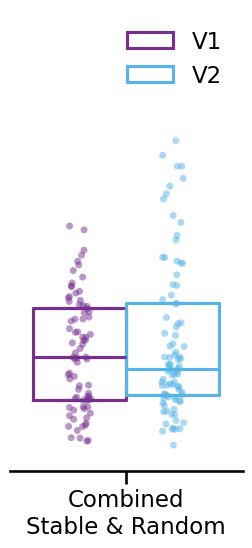

In [17]:
fig, ax = plt.subplots(figsize=(3,6))

probe_violation_df["combined_stage"] = True
u.box_strip_v1_vs_v2(probe_violation_df, x="combined_stage", order=None, y="violation_rate", ax=ax, xlabel="", ylabel="", dodge=True, alpha=0.5, width=0.8)

ax.set_ylim(0, 50)
ax.set_xticklabels(["Combined\nStable & Random"])

# Remove y-axis spine, labels, and ticks
ax.yaxis.set_visible(False)
sns.despine(ax=ax, left=True)

c.save_fig(fig, "fig3_probe_violation_rates_combined")

In [19]:
combstats = u.compare_v1_v2(probe_violation_df.query("stage == 9"), "violation_rate")
combstats["adj_pval"] = min(combstats["p_val_raw"].iloc[0] * 4, 1)
combstats

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw,adj_pval
0,True,False,39,44,mannwhitney,947.5,0.416759,1


In [20]:
u.compare_v1_v2_multi_sample(probe_violation_df, "violation_rate")

,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,0.37315,0.709037,False


# B


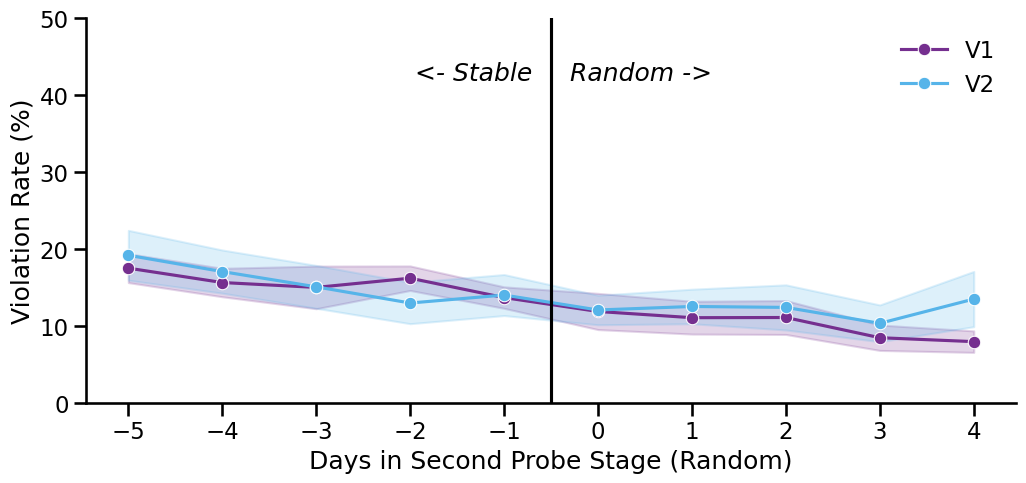

In [21]:
fig, ax = plt.subplots(figsize=(12,5))

sns.despine()

sns.lineplot(data=probe_violation_df, x="days_relative_to_stage_10", y="violation_rate", hue="fix_experiment", hue_order=c.HUE_ORDER_EXP, palette=c.EXP_PALETTE, marker="o", errorbar="se")
ax.set_ylim(0, 50)
ax.set_xticks(range(-5, 5))  # Set xticks from -5 to +4
ax.axvline(-0.5, color="black")
_ = ax.text(-0.3, 42, "Random ->", horizontalalignment="left", fontstyle="italic")
_ = ax.text(-0.7, 42, "<- Stable", horizontalalignment="right", fontstyle="italic")

_ = ax.set(xlabel="Days in Second Probe Stage (Random)", ylabel="Violation Rate (%)")

ax.legend(title="", frameon=False)

c.save_fig(fig, "fig3_probe_violation_rates_over_days")


# C


In [28]:
OUTLIER_ANIMAL = 'R047'

In [22]:
target_time_df = (
    tdf.query("has_reached_target_fixation == True")
    .groupby(["animal_id", "fix_experiment"], observed=True)[
        f"days_relative_to_stage_5"
    ]
    .min()
    .reset_index()
)

target_time_df.rename(
    columns={f"days_relative_to_stage_5": "days_to_target"},
    inplace=True,
)

target_time_df.head()


,animal_id,fix_experiment,days_to_target
0,R040,V1,13
1,R041,V2,11
2,R042,V1,12
3,R043,V2,6
4,R045,V2,11


In [29]:
probe_time_and_viol_df = pd.merge(probe_violation_df, target_time_df, on=["animal_id", "fix_experiment"], how="left")
probe_time_and_viol_df["outlier"] = probe_time_and_viol_df["animal_id"] == OUTLIER_ANIMAL
probe_time_and_viol_df.head()


,date,fix_experiment,animal_id,stage,days_relative_to_stage_10,violation_rate,combined_stage,days_to_target,outlier
0,2024-08-07,V2,R043,9.0,-5.0,14.673913,True,6,False
1,2024-08-08,V2,R043,9.0,-4.0,10.501193,True,6,False
2,2024-08-09,V2,R043,9.0,-3.0,8.184143,True,6,False
3,2024-08-10,V2,R043,9.0,-2.0,4.514673,True,6,False
4,2024-08-11,V1,R042,9.0,-5.0,19.444444,True,12,False


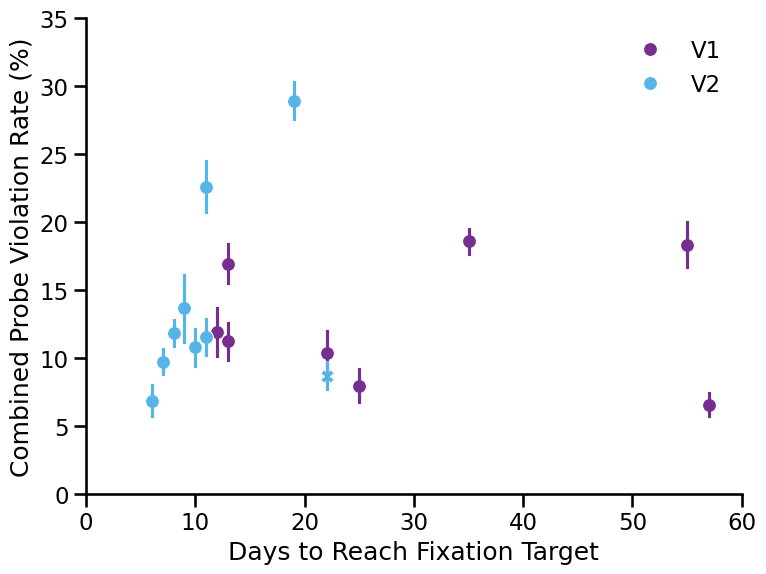

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
import warnings
warnings.filterwarnings(
    "ignore",
    message="Calling float on a single element Series is deprecated"
)

# …then your plotting code as before…
sns.lineplot(
    data=probe_time_and_viol_df.query("outlier == False"),
    x="days_to_target",
    y="violation_rate",
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    style="animal_id",
    marker="o",
    markersize=10,  # Increase marker size
    linestyle="",
    err_style="bars",
    errorbar="se",
    ax=ax,
)
sns.lineplot(
    data=probe_time_and_viol_df.query("outlier == True"),
    x="days_to_target",
    y="violation_rate",
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    style="animal_id",
    marker="X",
    markersize=10,  # Increase marker size
    linestyle="",
    err_style="bars",
    errorbar="se",
    ax=ax,
)

_ = ax.set(
    xlim=(0, 60),
    ylim=(0, 35),
    xlabel="Days to Reach Fixation Target",
    ylabel="Combined Probe Violation Rate (%)",
)

sns.despine()
plt.tight_layout()


ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3], labels=labels[1:3], frameon=False)
plt.tight_layout()
c.save_fig(fig, "fig3_probe_violation_rates_by_days_to_target")


In [103]:
# Random intercepts by animal_id
md = smf.mixedlm(
    formula="violation_rate ~ days_to_target * fix_experiment",
    data=probe_time_and_viol_df.query("animal_id !=@OUTLIER_ANIMAL"),
    groups=probe_time_and_viol_df.query("animal_id !=@OUTLIER_ANIMAL")["animal_id"]
)
mdf = md.fit(method='lbfgs')  # or 'nlopt' etc., whichever converges best
print(mdf.summary())

                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       violation_rate
No. Observations:       158           Method:                   REML          
No. Groups:             16            Scale:                    0.0021        
Min. group size:        9             Log-Likelihood:           230.1610      
Max. group size:        10            Converged:                Yes           
Mean group size:        9.9                                                   
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            0.125    0.030  4.123 0.000  0.066  0.185
fix_experiment[T.V2]                -0.147    0.054 -2.728 0.006 -0.253 -0.041
days_to_target                       0.000    0.001  0.073 0.942 -0.002  

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Outlier Analysis


In [105]:
probe_violation_df.query("animal_id == @OUTLIER_ANIMAL").agg(
    #violation rate mean and sd
    violation_rate_mean=("violation_rate", "mean"),
    violation_rate_sd=("violation_rate", "std")
)

,violation_rate
violation_rate_mean,0.086980
violation_rate_sd,0.031265


In [106]:
pdf = u.load_poke_df()

outlier_df = pdf.query("animal_id == @OUTLIER_ANIMAL and stage in @c.GROWING_STAGES")
outlier_df = u.compute_days_relative_to_stage(outlier_df.copy(), 5)

outlier_df.head()



Loading poke data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


,sessid,animal_id,trial,cpoke_dur,cpoke_iti,post_settling_violation,settling_violation,was_rewarded,fixation_dur,date,stage,fix_experiment,relative_cpoke_dur,was_valid,cpoke_tit_timeout_adj,prev_was_valid,datetime_col,days_relative_to_stage_5
0,965079,R047,1,0.2574,0.0223,0,1,0,0.401,01-Aug-2024 14:29:00,5.0,V2,-0.1436,False,0.0223,None,2024-08-01 14:29:00,0
1,965079,R047,1,0.0880,0.1134,0,1,0,0.401,01-Aug-2024 14:29:00,5.0,V2,-0.3130,False,0.1134,False,2024-08-01 14:29:00,0
2,965079,R047,1,0.0164,0.1020,0,1,0,0.401,01-Aug-2024 14:29:00,5.0,V2,-0.3846,False,0.1020,False,2024-08-01 14:29:00,0
3,965079,R047,1,0.0579,108.2671,0,1,0,0.401,01-Aug-2024 14:29:00,5.0,V2,-0.3431,False,108.2671,False,2024-08-01 14:29:00,0
4,965079,R047,1,0.0320,29.9668,0,1,0,0.401,01-Aug-2024 14:29:00,5.0,V2,-0.3690,False,29.9668,False,2024-08-01 14:29:00,0


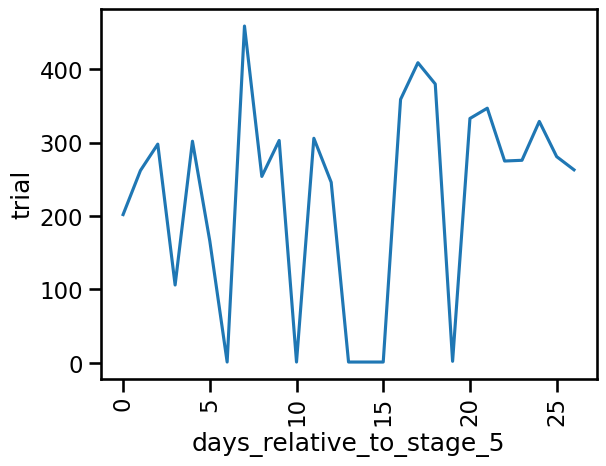

In [107]:
max_trials = outlier_df.groupby("days_relative_to_stage_5").trial.max().reset_index()
sns.lineplot(max_trials, x="days_relative_to_stage_5", y="trial")
_ = plt.xticks(rotation=90)


In [108]:
max_trials = outlier_df.groupby("date").trial.max().reset_index()
dates_with_max_trials_less_than_20 = max_trials[max_trials["trial"] < 20]["date"]
print(dates_with_max_trials_less_than_20)

6     07-Aug-2024 15:03:56
10    11-Aug-2024 14:00:55
13    14-Aug-2024 14:23:33
14    15-Aug-2024 14:21:29
15    16-Aug-2024 14:27:07
19    20-Aug-2024 14:17:12
Name: date, dtype: object


In [109]:
low_trial_pdf = outlier_df.query("date in @dates_with_max_trials_less_than_20")
low_trial_pdf.groupby("date").size()

date
07-Aug-2024 15:03:56     10
11-Aug-2024 14:00:55     23
14-Aug-2024 14:23:33     16
15-Aug-2024 14:21:29      6
16-Aug-2024 14:27:07    141
20-Aug-2024 14:17:12     18
dtype: int64

In [104]:
# Random intercepts by animal_id
md = smf.mixedlm(
    formula="violation_rate ~ days_to_target * fix_experiment",
    data=probe_time_and_viol_df,
    groups=probe_time_and_viol_df["animal_id"]
)
mdf = md.fit(method='lbfgs')  # or 'nlopt' etc., whichever converges best
print(mdf.summary())

                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       violation_rate
No. Observations:       168           Method:                   REML          
No. Groups:             17            Scale:                    0.0020        
Min. group size:        9             Log-Likelihood:           243.1853      
Max. group size:        10            Converged:                Yes           
Mean group size:        9.9                                                   
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            0.126    0.043  2.913 0.004  0.041  0.210
fix_experiment[T.V2]                -0.047    0.066 -0.707 0.480 -0.177  0.083
days_to_target                       0.000    0.001  0.048 0.962 -0.002  

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
